In [1]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

/opt/miniconda3/envs/minor/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/miniconda3/envs/minor/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /opt/miniconda3/envs/minor/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/miniconda3/envs/minor/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/minor/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/minor/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/minor/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` 

In [2]:
import torch
import torch.nn as nn
from torchvision import models

# Define same architecture used during training
class CovidDenseNet(nn.Module):
    def __init__(self, num_classes=3):
        super(CovidDenseNet, self).__init__()
        # Load DenseNet121 backbone
        self.backbone = models.densenet201(pretrained=False)
        num_ftrs = self.backbone.classifier.in_features
        # Replace classifier
        self.backbone.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.backbone(x)

# Instantiate model
model = CovidDenseNet(num_classes=3)

# Load trained weights
checkpoint = torch.load("models/chexnet201_finetuned.pth", map_location="cpu")
model.load_state_dict(checkpoint)
model.eval()

/opt/miniconda3/envs/minor/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/minor/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/var/folders/fz/sd4mlm5j5xq82d0vlcyb4sgm0000gn/T/ipykernel_12201/3092288555.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the defau

CovidDenseNet(
  (backbone): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momen

In [3]:
from torchvision import transforms
from PIL import Image

# Preprocessing (must match training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load an image
img_path = "covid_qu_ex_masked/test/COVID-19/covid_1582.png"
image = Image.open(img_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0)

# Predict
with torch.no_grad():
    outputs = model(input_tensor)
    probs = torch.softmax(outputs, dim=1)[0]
    pred_class = torch.argmax(probs).item()

classes = ["COVID-19", "Non-COVID", "Normal"]
print("Prediction:", classes[pred_class])
print("Probabilities:", probs.tolist())

Prediction: COVID-19
Probabilities: [0.8445804119110107, 0.10296307504177094, 0.0524565726518631]


In [4]:
def predict_fn(images):
    model.eval()
    images = [transform(Image.fromarray(img)).unsqueeze(0) for img in images]
    images = torch.cat(images).to("cpu")
    with torch.no_grad():
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
    return probs

# image-covid19

In [5]:
# Load one test image
img_path = "covid_qu_ex_masked/test/COVID-19/covid_1582.png"
image = Image.open(img_path).convert("RGB")
image_np = np.array(image)

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain prediction
explanation = explainer.explain_instance(
    image_np,          # raw image in numpy
    predict_fn,        # function returning class probabilities
    top_labels=3,      # number of top classes to explain
    hide_color=0,      # background color for masked regions
    num_samples=1000   # number of perturbed samples
)

100%|██████████| 1000/1000 [01:33<00:00, 10.67it/s]


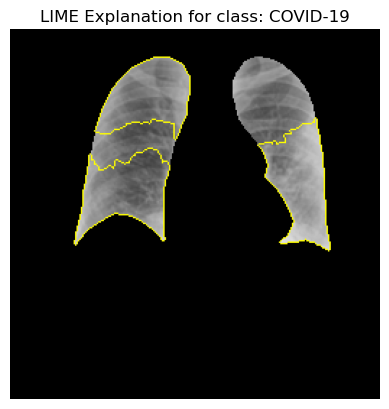

In [6]:
# Pick the class index that was predicted
predicted_label = np.argmax(predict_fn([image_np])[0])

# Get explanation for this label
temp, mask = explanation.get_image_and_mask(
    label=predicted_label,
    positive_only=True,
    hide_rest=False,
    num_features=4,       # number of superpixels to highlight
    min_weight=0.01
)

# Plot result
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f"LIME Explanation for class: {classes[predicted_label]}")
plt.axis('off')
plt.show()

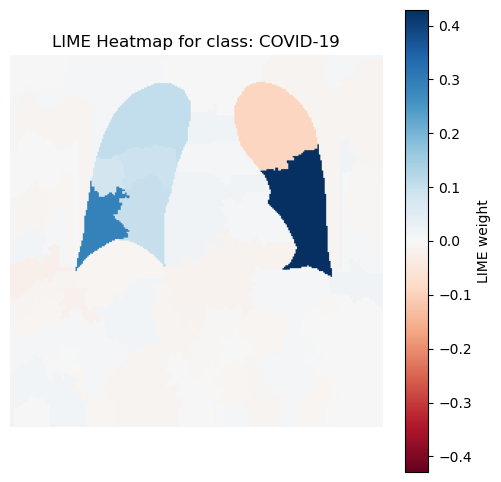

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Select the predicted class (same one LIME explained)
ind = explanation.top_labels[0]

# Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

# Plot heatmap with symmetrical colorbar
plt.figure(figsize=(6,6))
plt.imshow(heatmap, cmap='RdBu', vmin=-abs(heatmap).max(), vmax=abs(heatmap).max())
plt.colorbar(label="LIME weight")
plt.title(f"LIME Heatmap for class: {classes[ind]}")
plt.axis("off")
plt.show()

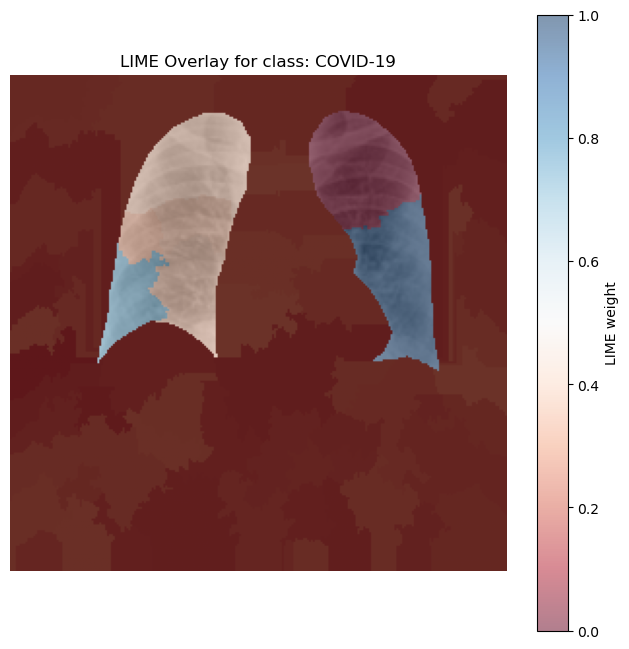

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Original image (convert to numpy)
org_img_path = "covid_qu_ex/Infection Segmentation Data/Infection Segmentation Data/Test/COVID-19/images/covid_1582.png"
org_image = Image.open(img_path).convert("RGB")
original_img = np.array(image)

# Select the predicted class explained
ind = explanation.top_labels[0]

# Map weights to superpixels
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

# Normalize heatmap for overlay
heatmap_norm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

plt.figure(figsize=(8,8))

# Show original image
plt.imshow(original_img, cmap="gray")

# Overlay heatmap with transparency
plt.imshow(heatmap_norm, cmap="RdBu", alpha=0.5)

plt.colorbar(label="LIME weight")
plt.title(f"LIME Overlay for class: {classes[ind]}")
plt.axis("off")
plt.show()


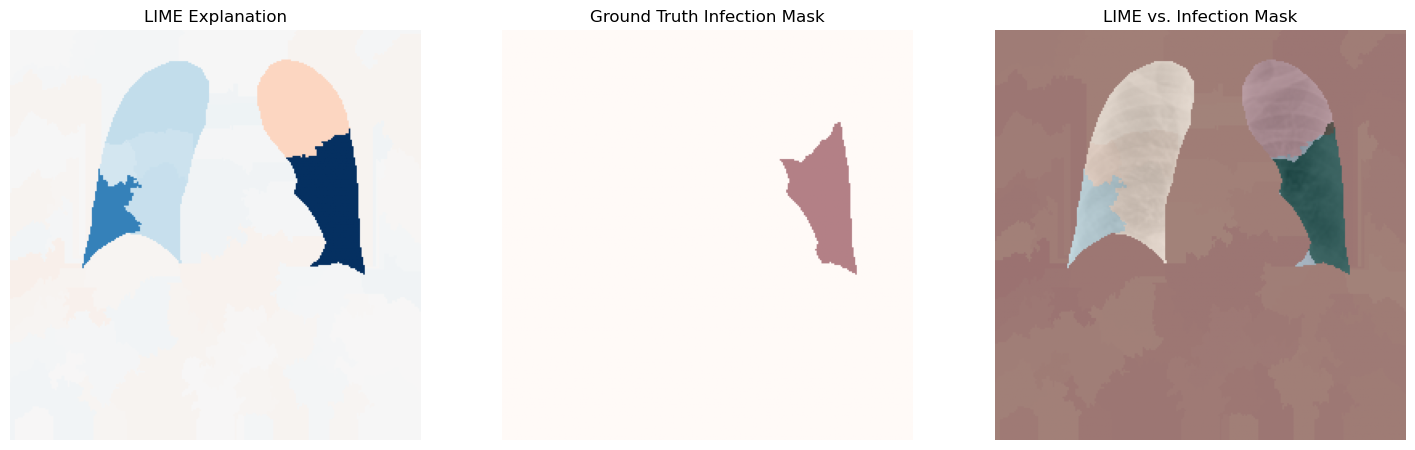

In [9]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load original image
original_img = np.array(image)

# Load infection mask (grayscale, then normalize to 0-1)
mask_path = "covid_qu_ex/Infection Segmentation Data/Infection Segmentation Data/Test/COVID-19/infection masks/covid_1582.png"
infection_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
infection_mask = cv2.resize(infection_mask, (original_img.shape[1], original_img.shape[0]))
infection_mask = (infection_mask > 0).astype(np.uint8)

# Select the predicted class
ind = explanation.top_labels[0]

# Get LIME weights as heatmap
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
heatmap_norm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

# --- Plotting ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original + LIME overlay
axes[0].imshow(heatmap, cmap='RdBu', vmin=-abs(heatmap).max(), vmax=abs(heatmap).max())
axes[0].set_title("LIME Explanation")
axes[0].axis("off")

# Original + Infection mask
axes[1].imshow(infection_mask, cmap="Reds", alpha=0.5)
axes[1].set_title("Ground Truth Infection Mask")
axes[1].axis("off")

# Overlay both
axes[2].imshow(original_img, cmap="gray")
axes[2].imshow(heatmap_norm, cmap="RdBu", alpha=0.5)
axes[2].imshow(infection_mask, cmap="Greens", alpha=0.4)
axes[2].set_title("LIME vs. Infection Mask")
axes[2].axis("off")

plt.show()


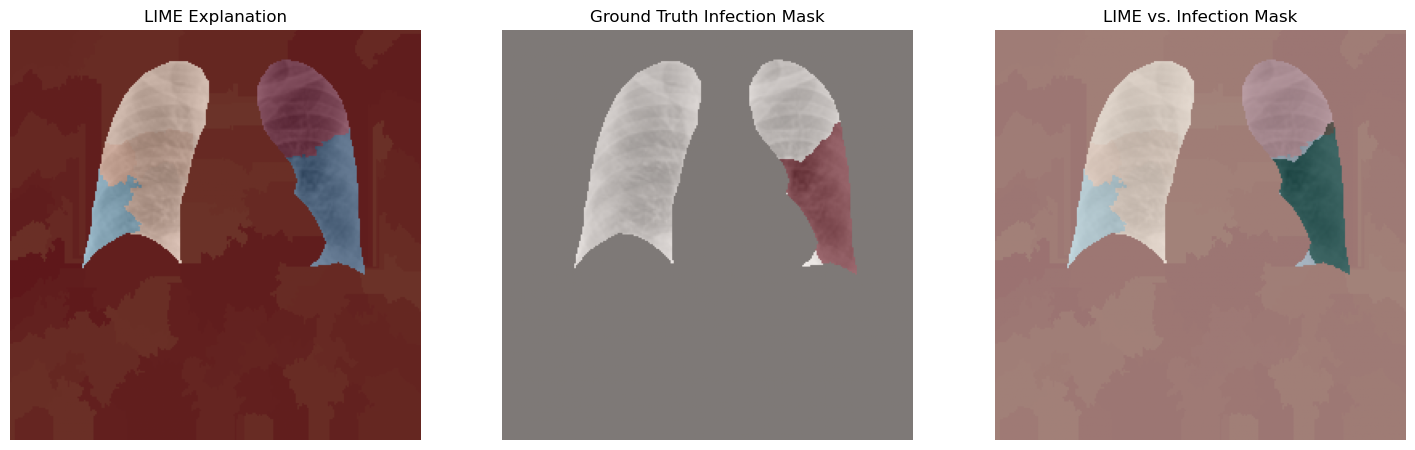

In [10]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load original image
original_img = np.array(image)

# Load infection mask (grayscale, then normalize to 0-1)
mask_path = "covid_qu_ex/Infection Segmentation Data/Infection Segmentation Data/Test/COVID-19/infection masks/covid_1582.png"
infection_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
infection_mask = cv2.resize(infection_mask, (original_img.shape[1], original_img.shape[0]))
infection_mask = (infection_mask > 0).astype(np.uint8)

# Select the predicted class
ind = explanation.top_labels[0]

# Get LIME weights as heatmap
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
heatmap_norm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

# --- Plotting ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original + LIME overlay
axes[0].imshow(original_img, cmap="gray")
axes[0].imshow(heatmap_norm, cmap="RdBu", alpha=0.5)
axes[0].set_title("LIME Explanation")
axes[0].axis("off")

# Original + Infection mask
axes[1].imshow(original_img, cmap="gray")
axes[1].imshow(infection_mask, cmap="Reds", alpha=0.5)
axes[1].set_title("Ground Truth Infection Mask")
axes[1].axis("off")

# Overlay both
axes[2].imshow(original_img, cmap="gray")
axes[2].imshow(heatmap_norm, cmap="RdBu", alpha=0.5)
axes[2].imshow(infection_mask, cmap="Greens", alpha=0.4)
axes[2].set_title("LIME vs. Infection Mask")
axes[2].axis("off")

plt.show()


# image-nonCovid

In [11]:
from torchvision import transforms
from PIL import Image

# Preprocessing (must match training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load an image
img_path = "covid_qu_ex_masked/test/Non-COVID/non_COVID (3251).png"
image = Image.open(img_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0)

# Predict
with torch.no_grad():
    outputs = model(input_tensor)
    probs = torch.softmax(outputs, dim=1)[0]
    pred_class = torch.argmax(probs).item()

classes = ["COVID-19", "Non-COVID", "Normal"]
print("Prediction:", classes[pred_class])
print("Probabilities:", probs.tolist())

Prediction: Non-COVID
Probabilities: [0.00017083925195038319, 0.9993269443511963, 0.0005022111581638455]


In [12]:
# Load one test image
img_path = "covid_qu_ex_masked/test/Non-COVID/non_COVID (3251).png"
image = Image.open(img_path).convert("RGB")
image_np = np.array(image)

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain prediction
explanation = explainer.explain_instance(
    image_np,          # raw image in numpy
    predict_fn,        # function returning class probabilities
    top_labels=3,      # number of top classes to explain
    hide_color=0,      # background color for masked regions
    num_samples=1000   # number of perturbed samples
)

100%|██████████| 1000/1000 [01:50<00:00,  9.06it/s]


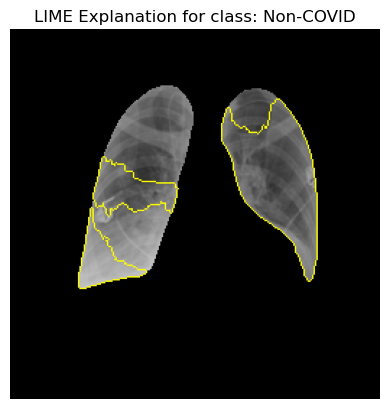

In [13]:
# Pick the class index that was predicted
predicted_label = np.argmax(predict_fn([image_np])[0])

# Get explanation for this label
temp, mask = explanation.get_image_and_mask(
    label=predicted_label,
    positive_only=True,
    hide_rest=False,
    num_features=4,       # number of superpixels to highlight
    min_weight=0.01
)

# Plot result
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f"LIME Explanation for class: {classes[predicted_label]}")
plt.axis('off')
plt.show()

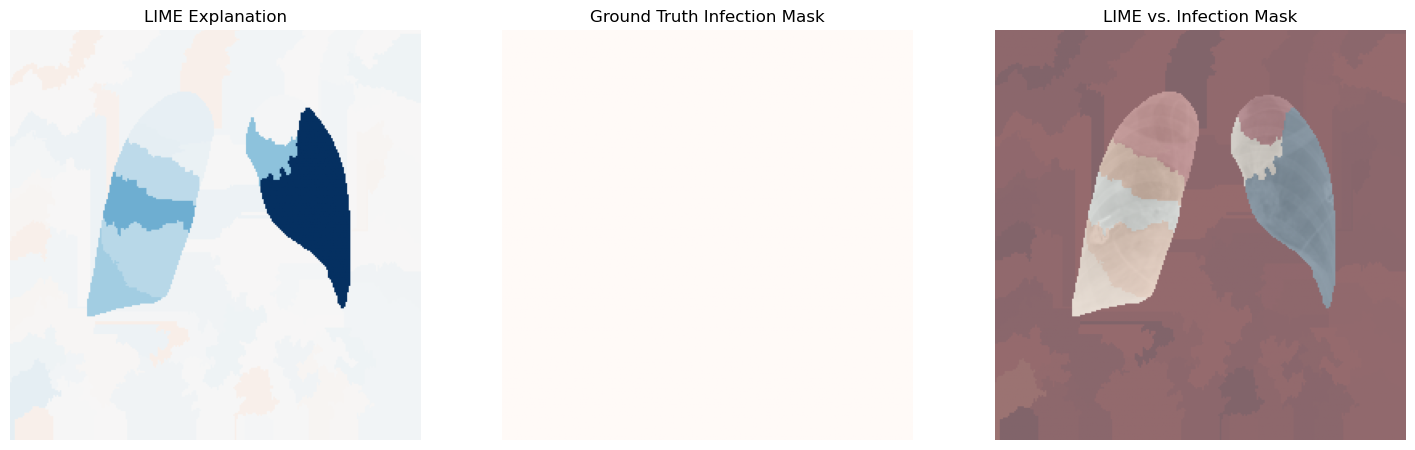

In [14]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load original image
original_img = np.array(image)

# Load infection mask (grayscale, then normalize to 0-1)
mask_path = "covid_qu_ex/Infection Segmentation Data/Infection Segmentation Data/Test/Non-COVID/infection masks/non_COVID (3251).png"
infection_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
infection_mask = cv2.resize(infection_mask, (original_img.shape[1], original_img.shape[0]))
infection_mask = (infection_mask > 0).astype(np.uint8)

# Select the predicted class
ind = explanation.top_labels[0]

# Get LIME weights as heatmap
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
heatmap_norm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

# --- Plotting ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original + LIME overlay
axes[0].imshow(heatmap, cmap='RdBu', vmin=-abs(heatmap).max(), vmax=abs(heatmap).max())
axes[0].set_title("LIME Explanation")
axes[0].axis("off")

# Original + Infection mask
axes[1].imshow(infection_mask, cmap="Reds", alpha=0.5)
axes[1].set_title("Ground Truth Infection Mask")
axes[1].axis("off")

# Overlay both
axes[2].imshow(original_img, cmap="gray")
axes[2].imshow(heatmap_norm, cmap="RdBu", alpha=0.5)
axes[2].imshow(infection_mask, cmap="Greens", alpha=0.4)
axes[2].set_title("LIME vs. Infection Mask")
axes[2].axis("off")

plt.show()


# image-normal

In [15]:
from torchvision import transforms
from PIL import Image

# Preprocessing (must match training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load an image
img_path = "covid_qu_ex_masked/test/Normal/Normal (1).png"
image = Image.open(img_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0)

# Predict
with torch.no_grad():
    outputs = model(input_tensor)
    probs = torch.softmax(outputs, dim=1)[0]
    pred_class = torch.argmax(probs).item()

classes = ["COVID-19", "Non-COVID", "Normal"]
print("Prediction:", classes[pred_class])
print("Probabilities:", probs.tolist())

Prediction: Normal
Probabilities: [0.0011753946309909225, 0.04364500567317009, 0.9551796317100525]


In [16]:
# Load one test image
img_path = "covid_qu_ex_masked/test/Normal/Normal (1).png"
image = Image.open(img_path).convert("RGB")
image_np = np.array(image)

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain prediction
explanation = explainer.explain_instance(
    image_np,          # raw image in numpy
    predict_fn,        # function returning class probabilities
    top_labels=3,      # number of top classes to explain
    hide_color=0,      # background color for masked regions
    num_samples=1000   # number of perturbed samples
)
explainer = lime_image.LimeImageExplainer()

100%|██████████| 1000/1000 [02:02<00:00,  8.14it/s]


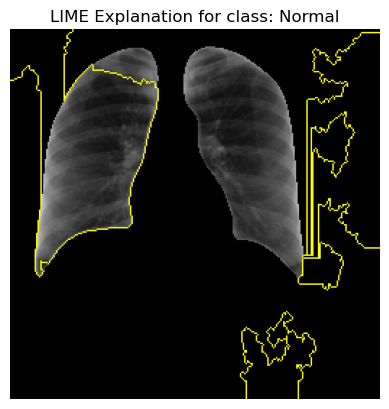

In [17]:
# Pick the class index that was predicted
predicted_label = np.argmax(predict_fn([image_np])[0])

# Get explanation for this label
temp, mask = explanation.get_image_and_mask(
    label=predicted_label,
    positive_only=True,
    hide_rest=False,
    num_features=10,       # number of superpixels to highlight
    min_weight=0.01
)

# Plot result
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f"LIME Explanation for class: {classes[predicted_label]}")
plt.axis('off')
plt.show()

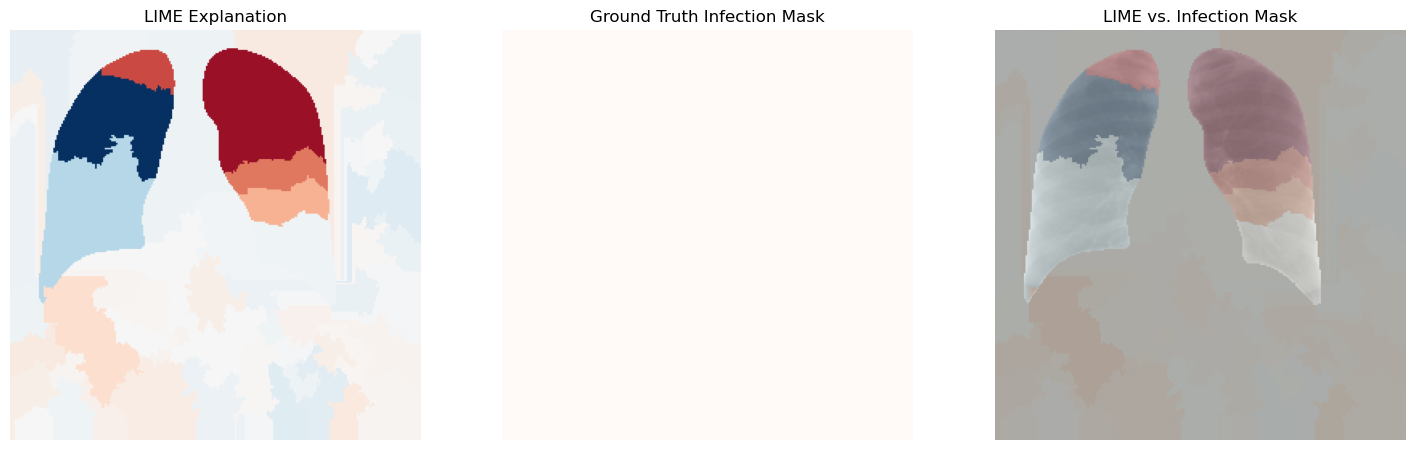

In [18]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load original image
original_img = np.array(image)

# Load infection mask (grayscale, then normalize to 0-1)
mask_path = "covid_qu_ex/Infection Segmentation Data/Infection Segmentation Data/Test/Normal/infection masks/Normal (1).png"
infection_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
infection_mask = cv2.resize(infection_mask, (original_img.shape[1], original_img.shape[0]))
infection_mask = (infection_mask > 0).astype(np.uint8)

# Select the predicted class
ind = explanation.top_labels[0]

# Get LIME weights as heatmap
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
heatmap_norm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

# --- Plotting ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original + LIME overlay
axes[0].imshow(heatmap, cmap='RdBu', vmin=-abs(heatmap).max(), vmax=abs(heatmap).max())
axes[0].set_title("LIME Explanation")
axes[0].axis("off")

# Original + Infection mask
axes[1].imshow(infection_mask, cmap="Reds", alpha=0.5)
axes[1].set_title("Ground Truth Infection Mask")
axes[1].axis("off")

# Overlay both
axes[2].imshow(original_img, cmap="gray")
axes[2].imshow(heatmap_norm, cmap="RdBu", alpha=0.5)
axes[2].imshow(infection_mask, cmap="Greens", alpha=0.4)
axes[2].set_title("LIME vs. Infection Mask")
axes[2].axis("off")

plt.show()


# Generating infection masks for all test data

In [19]:
def predict_fn(images):
    model.eval()
    images = [transform(Image.fromarray(img)).unsqueeze(0) for img in images]
    images = torch.cat(images).to("cpu")
    with torch.no_grad():
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
    return probs

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
from lime import lime_image
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define paths
test_folder = "covid_qu_ex_masked/test/COVID-19"
save_root = "predicted_infection_masks/cheXCaps201/test/COVID-19"

# Create output directories if they don't exist
os.makedirs(save_root, exist_ok=True)

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Get all test image filenames and select first 100
image_files = [f for f in os.listdir(test_folder) if f.endswith((".png", ".jpg"))]
image_files = image_files[:100]  # limit to first 100 images

# Process selected images with a progress bar
for filename in tqdm(image_files, desc="Generating LIME infection masks", unit="image"):
    img_path = os.path.join(test_folder, filename)
    
    # Load image and convert to RGB numpy array
    image = Image.open(img_path).convert("RGB")
    image_np = np.array(image)

    # Get LIME explanation
    explanation = explainer.explain_instance(
        image_np,
        predict_fn,           # Predefined prediction function
        top_labels=1,         # Use top predicted class
        hide_color=0,
        num_samples=1000
    )

    # Get predicted class directly from explanation
    predicted_label = explanation.top_labels[0]

    # Build heatmap for predicted label
    dict_heatmap = dict(explanation.local_exp[predicted_label])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

    # ✅ Keep only positive relevance (remove negative LIME contributions)
    heatmap = np.maximum(heatmap, 0)

    # ✅ Normalize safely (avoid divide-by-zero)
    heatmap_norm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

    # ✅ Convert to binary infection mask
    threshold = 0.5
    bw_mask = (heatmap_norm > threshold).astype(np.uint8) * 255
    
    # ✅ Ensure consistent white = infection
    if np.mean(bw_mask) > 128:
        bw_mask = 255 - bw_mask

    # Save mask
    save_path = os.path.join(save_root, filename)
    cv2.imwrite(save_path, bw_mask)

print("✅ 100 predicted infection masks saved successfully (consistent white = infection).")

Generating LIME infection masks: 100%|██████████| 100/100 [3:13:03<00:00, 115.84s/image]

✅ 100 predicted infection masks saved successfully (consistent white = infection).


In [23]:
import os
import cv2
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from scipy.spatial.distance import directed_hausdorff

def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union > 0 else 1.0

def dice_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    return 2 * intersection / (y_true.sum() + y_pred.sum()) if (y_true.sum() + y_pred.sum()) > 0 else 1.0

def hausdorff_distance(y_true, y_pred):
    true_points = np.column_stack(np.where(y_true))
    pred_points = np.column_stack(np.where(y_pred))
    if len(true_points) == 0 or len(pred_points) == 0:
        return np.nan
    forward_hd = directed_hausdorff(true_points, pred_points)[0]
    backward_hd = directed_hausdorff(pred_points, true_points)[0]
    return max(forward_hd, backward_hd)

def evaluate_mask_metrics(gt_folder, pred_folder):
    gt_files = {f for f in os.listdir(gt_folder) if f.endswith(('.png', '.jpg'))}
    pred_files = {f for f in os.listdir(pred_folder) if f.endswith(('.png', '.jpg'))}

    # Find common filenames present in both folders
    common_files = sorted(list(gt_files & pred_files))

    if not common_files:
        print("No matching filenames found between predicted and ground truth folders.")
        return None

    metrics = {
        'iou': [], 'dice': [], 'accuracy': [],
        'precision': [], 'recall': [], 'f1_score': [], 'hausdorff': []
    }

    for filename in common_files:
        gt_path = os.path.join(gt_folder, filename)
        pred_path = os.path.join(pred_folder, filename)

        gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
        pred_mask = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)

        if gt_mask is None or pred_mask is None:
            continue  # Skip any missing file read
        pred_mask = cv2.resize(pred_mask, (gt_mask.shape[1], gt_mask.shape[0]))

        # Convert to binary 0-1
        gt_mask = (gt_mask > 0).astype(np.uint8)
        pred_mask = (pred_mask > 0).astype(np.uint8)

        gt_flat = gt_mask.flatten()
        pred_flat = pred_mask.flatten()

        metrics['iou'].append(iou_score(gt_mask, pred_mask))
        metrics['dice'].append(dice_score(gt_mask, pred_mask))
        metrics['accuracy'].append(accuracy_score(gt_flat, pred_flat))
        metrics['precision'].append(precision_score(gt_flat, pred_flat, zero_division=0))
        metrics['recall'].append(recall_score(gt_flat, pred_flat, zero_division=0))
        metrics['f1_score'].append(f1_score(gt_flat, pred_flat, zero_division=0))
        metrics['hausdorff'].append(hausdorff_distance(gt_mask, pred_mask))

    avg_metrics = {k: np.nanmean(v) for k, v in metrics.items()}
    return avg_metrics


# Example usage
ground_truth_folder = "covid_qu_ex/Infection Segmentation Data/Infection Segmentation Data/Test/COVID-19/infection masks"
predicted_mask_folder = "predicted_infection_masks/cheXCaps201/test/COVID-19"

results = evaluate_mask_metrics(ground_truth_folder, predicted_mask_folder)

if results:
    print("Evaluation results for common masks:")
    for metric, value in results.items():
        print(f"{metric}: {value:.4f}")

Evaluation results for common masks:
iou: 0.2862
dice: 0.4174
accuracy: 0.8726
precision: 0.5989
recall: 0.4015
f1_score: 0.4174
hausdorff: 93.6084
